In [1]:
# IMPORT LIBRARIES
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import os
import random
from IPython.display import Audio, clear_output, display
from sklearn.preprocessing import StandardScaler
# DL libraries
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
import librosa
import math

# Restoration of Low-Quality Audio Using Convolutional AutoEncoder:
##Investigation and Comparison of Different Models Trained with Mel Spectrograms

*Student: Marco Lorenzetti*

*ID: 2056112*

-----------------------------------------------------------
Useful Functions

In [2]:
def print_recons(X, X_noised, recons):
    X, X_noised, recons = X.cpu().detach().numpy(), X_noised.cpu().detach().numpy(), recons.cpu().detach().numpy()
    # Print Some Reconstructions
    figsize = (15, 2.25)
    fontsize = 8
    plt.figure(figsize = figsize)

    start = 4
    n_images = 5

    for i in range(n_images):
        plt.subplot(1, n_images, i+1)
        # librosa.display.specshow(librosa.power_to_db(X[start+i+1][0], ref=np.max), sr=22050)
        plt.imshow(X[start+i+1][0], origin='lower')
        plt.title('Training Image ' + str(i+1), fontsize = fontsize)
        # plt.axis("off")

    plt.figure(figsize = figsize)

    for i in range(n_images):
        plt.subplot(1, n_images, i+1)
        # librosa.display.specshow(librosa.power_to_db(X_noised[start+i+1][0], ref=np.max), sr=22050)
        plt.imshow(X_noised[start+i+1][0], origin='lower')
        plt.title('Noised Image ' + str(i+1), fontsize = fontsize)
        # plt.axis("off")

    plt.figure(figsize = figsize)

    for i in range(n_images):
        plt.subplot(1, n_images, i+1)
        # pic = recons.data
        # librosa.display.specshow(librosa.power_to_db(pic[start+i+1][0], ref=np.max), sr=22050)
        plt.imshow(recons[start+i+1][0], origin='lower')
        plt.title('Reconstructed Image ' + str(i+1), fontsize = fontsize)
        # plt.axis("off")

    plt.show()

### Training function
def train_epoch(encoder, decoder, device, dataloader, dataloader_noised, loss_fn, optimizer, k, weight_decay, visualize=False):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    losses = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for j, (image_batch, image_batch_noised) in enumerate(zip(dataloader, dataloader_noised)):
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        image_batch_noised = image_batch_noised.to(device)
        # Decode data
        encoded_data = encoder(image_batch_noised)
        decoded_data = decoder(encoded_data)
        # print(decoded_data.shape)
        # # Evaluate loss
        # loss = loss_fn(decoded_data, image_batch)
        #-----------------------

        # Calculate the reconstruction loss
        reconstruction_loss = loss_fn(decoded_data[:,:,:-1,:-1], image_batch)

        # Calculate the regularization term (L2 norm of the parameters)
        l2_regularization = 0.0
        for param in encoder.parameters():
            l2_regularization += torch.norm(param)**2
        for param in decoder.parameters():
            l2_regularization += torch.norm(param)**2
        l2_regularization *= 0.5 * weight_decay

        # Add the regularization term to the loss
        loss = reconstruction_loss + l2_regularization
        #-----------------------------

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.detach().cpu().numpy())
        # print(f'------ Loss: {loss:.4f}')
    losses = np.mean(losses)

    if visualize:
        if k % 15 == 0:
            print_recons(image_batch, image_batch_noised, decoded_data)

    return losses

### Testing function
def test_epoch(encoder, decoder, device, dataloader, dataloader_noised, loss_fn, weight_decay):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        conc_out = []
        conc_label = []
        l2_regularization = 0.0

        for image_batch, image_batch_noised in zip(dataloader, dataloader_noised):
            image_batch = image_batch.to(device)
            image_batch_noised = image_batch_noised.to(device)

            encoded_data = encoder(image_batch_noised)
            decoded_data = decoder(encoded_data)
            decoded_data = decoded_data[:,:,:-1,:-1]

            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())

            # Calculate the L2 regularization term
            for param in encoder.parameters():
                l2_regularization += torch.norm(param)**2
            for param in decoder.parameters():
                l2_regularization += torch.norm(param)**2

        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)

        # Calculate the reconstruction loss
        reconstruction_loss = loss_fn(conc_out, conc_label)

        # Calculate the total loss with L2 regularization
        l2_regularization *= 0.5 * weight_decay
        val_loss = reconstruction_loss + l2_regularization

    return val_loss.data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# defining the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

Mounted at /content/drive


device(type='cuda')

Load Data and create Training-Test Batches

In [4]:
class CustomNumpyDataset(Dataset):
    def __init__(self, np_file):
        self.data = np.load(np_file)
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # Converti in tensore
            # transforms.Normalize(mean=[0.5], std=[0.5])  # Standardizzazione
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        array = self.data[idx]
        transformed_array = self.transform(array)  # Applica le trasformazioni
        return transformed_array


# Sostituisci 'your_numpy_file.npy' con il percorso del tuo file numpy

custom_dataset = CustomNumpyDataset('/content/drive/MyDrive/NNDL/spectrum/clean spectrograms.npy')
custom_dataset_noised = CustomNumpyDataset('/content/drive/MyDrive/NNDL/spectrum/distorted spectrograms.npy')

# Shuffle datasets
random_indexes = list(range(len(custom_dataset)))
random.shuffle(random_indexes)

custom_dataset = torch.utils.data.Subset(custom_dataset, random_indexes)
custom_dataset_noised = torch.utils.data.Subset(custom_dataset_noised, random_indexes)

# Cut training datasets
perc = 0.8
new_len = int(perc * len(custom_dataset))

# Creare dataset2 che contiene solo l'80% dei tensori di custom_dataset
custom_dataset_2 = torch.utils.data.Subset(custom_dataset, range(new_len))
custom_dataset_noised_2 = torch.utils.data.Subset(custom_dataset_noised, range(new_len))

# Test sets
test_dataset = torch.utils.data.Subset(custom_dataset, range(new_len, len(custom_dataset)))
test_dataset_noised = torch.utils.data.Subset(custom_dataset_noised, range(new_len, len(custom_dataset_noised)))

print(f'training samples: {len(custom_dataset_2)}')
print(f'test samples: {len(test_dataset)}')

dataloader = DataLoader(custom_dataset_2, batch_size=64, shuffle=False, drop_last=True)
dataloader_noised = DataLoader(custom_dataset_noised_2, batch_size=64, shuffle=False, drop_last=True)

test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)
test_dataloader_noised = DataLoader(test_dataset_noised, batch_size=64, shuffle=False, drop_last=True)

training samples: 2387
test samples: 597


------------------------------------------------------------------------------------------

# Only convolutioinal Model

In [ ]:
# ENCODER - DECODER

class Encoder(nn.Module):

    def __init__(self):
        super().__init__()

        ### Convolutional section
        self.encoder_cnn = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, 3, stride=1, padding=1),
            torch.nn.Dropout(0.2),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2, stride=1),
            torch.nn.Conv2d(16, 32, 3, stride=1, padding=1),  # b, 8, 3, 3
            torch.nn.Dropout(0.2),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2, stride=1),  # b, 8, 2, 2
            torch.nn.Conv2d(32, 64, 3, stride=1, padding=1),  # b, 8, 3, 3
            torch.nn.Dropout(0.2),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2, stride=1)
        )

    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        return x

class Decoder(nn.Module):

  def __init__(self):
      super().__init__()

      ### Convolutional section
      self.decoder_conv =nn.Sequential(
          torch.nn.Upsample(scale_factor=1, mode='nearest'),
          torch.nn.Conv2d(64, 32, 3, stride=1, padding=1),  # b, 16, 10, 10
          torch.nn.ReLU(True),
          torch.nn.Upsample(scale_factor=1, mode='nearest'),
          torch.nn.Conv2d(32, 16, 3, stride=1, padding=2),  # b, 16, 10, 10
          torch.nn.ReLU(True),
          torch.nn.Upsample(scale_factor=1, mode='nearest'),
          torch.nn.Conv2d(16, 1, 5, stride=1, padding=3)  # b, 8, 3, 3

          # torch.nn.Sigmoid()
      )

  def forward(self, x):
      # Apply transposed convolutions
      x = self.decoder_conv(x)
      return x

Selected device: cuda
EPOCH 1/76


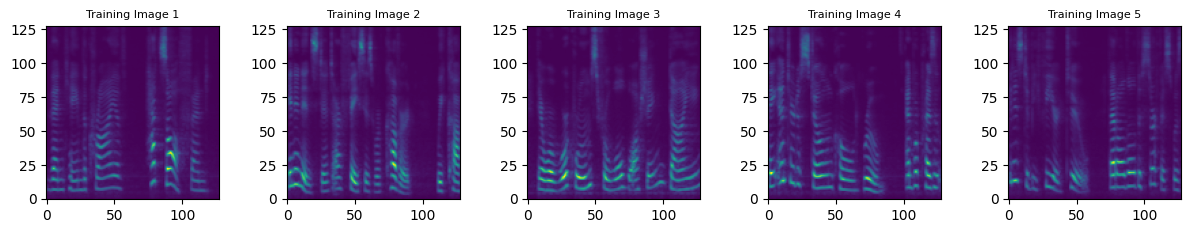

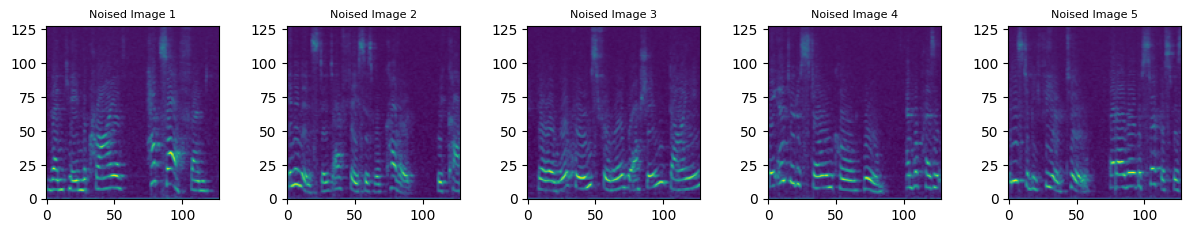

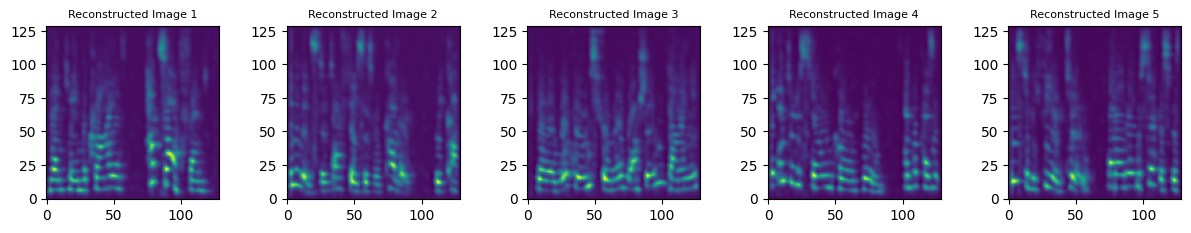

TRAIN - EPOCH 1/76 - loss: 0.1657
VALIDATION - EPOCH 1/76 - loss: 0.2088

--------------------------------------------------------------------------------
EPOCH 2/76
TRAIN - EPOCH 2/76 - loss: 0.1184
VALIDATION - EPOCH 2/76 - loss: 0.2100

--------------------------------------------------------------------------------
EPOCH 3/76
TRAIN - EPOCH 3/76 - loss: 0.1102
VALIDATION - EPOCH 3/76 - loss: 0.2007

--------------------------------------------------------------------------------
EPOCH 4/76
TRAIN - EPOCH 4/76 - loss: 0.1072
VALIDATION - EPOCH 4/76 - loss: 0.2018

--------------------------------------------------------------------------------
EPOCH 5/76
TRAIN - EPOCH 5/76 - loss: 0.1055
VALIDATION - EPOCH 5/76 - loss: 0.2017

--------------------------------------------------------------------------------
EPOCH 6/76
TRAIN - EPOCH 6/76 - loss: 0.1036
VALIDATION - EPOCH 6/76 - loss: 0.2010

--------------------------------------------------------------------------------
EPOCH 7/76
TRAI

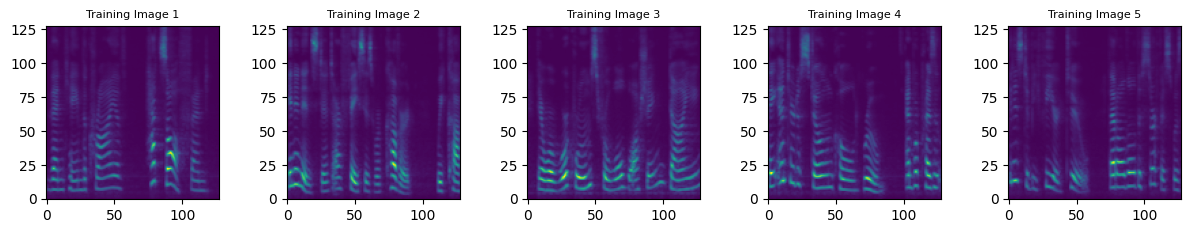

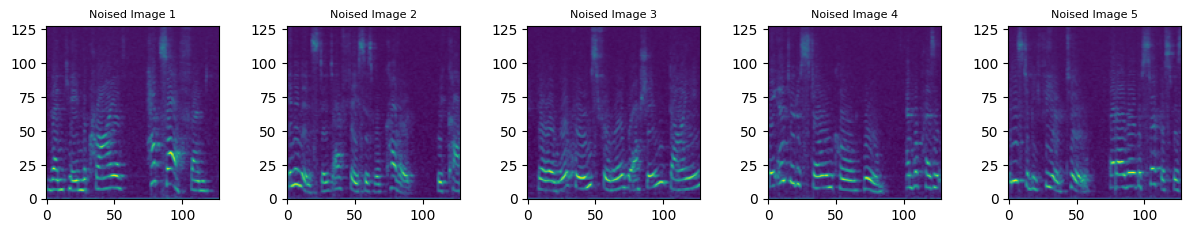

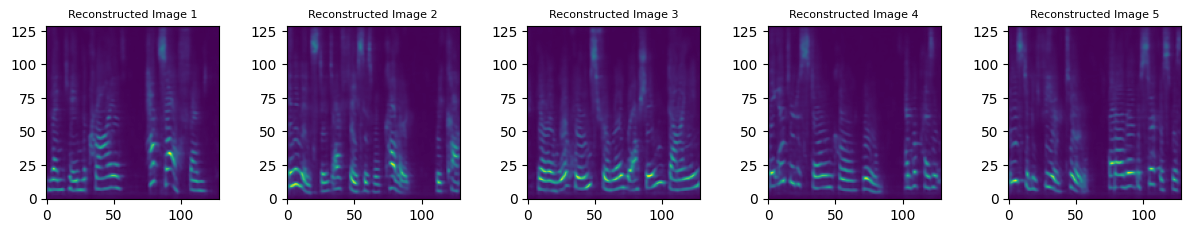

TRAIN - EPOCH 16/76 - loss: 0.0974
VALIDATION - EPOCH 16/76 - loss: 0.2060

--------------------------------------------------------------------------------
EPOCH 17/76
TRAIN - EPOCH 17/76 - loss: 0.0969
VALIDATION - EPOCH 17/76 - loss: 0.2034

--------------------------------------------------------------------------------
EPOCH 18/76
TRAIN - EPOCH 18/76 - loss: 0.0966
VALIDATION - EPOCH 18/76 - loss: 0.2071

--------------------------------------------------------------------------------
EPOCH 19/76
TRAIN - EPOCH 19/76 - loss: 0.0964
VALIDATION - EPOCH 19/76 - loss: 0.2068

--------------------------------------------------------------------------------
EPOCH 20/76
TRAIN - EPOCH 20/76 - loss: 0.0958
VALIDATION - EPOCH 20/76 - loss: 0.2033

--------------------------------------------------------------------------------
EPOCH 21/76
TRAIN - EPOCH 21/76 - loss: 0.0958
VALIDATION - EPOCH 21/76 - loss: 0.2086

-------------------------------------------------------------------------------

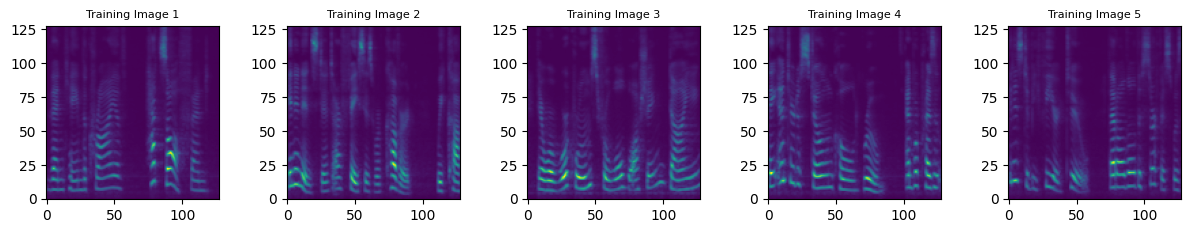

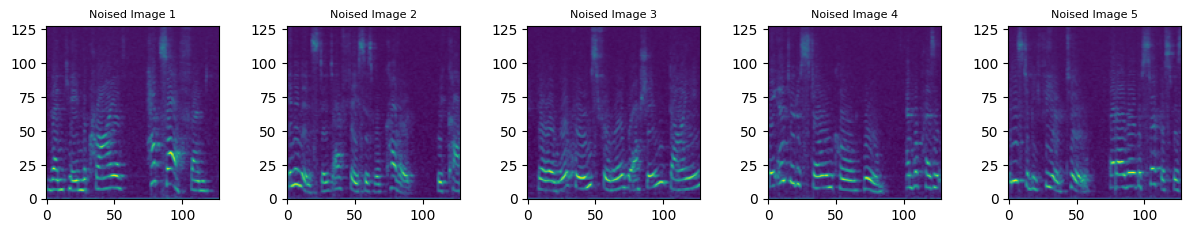

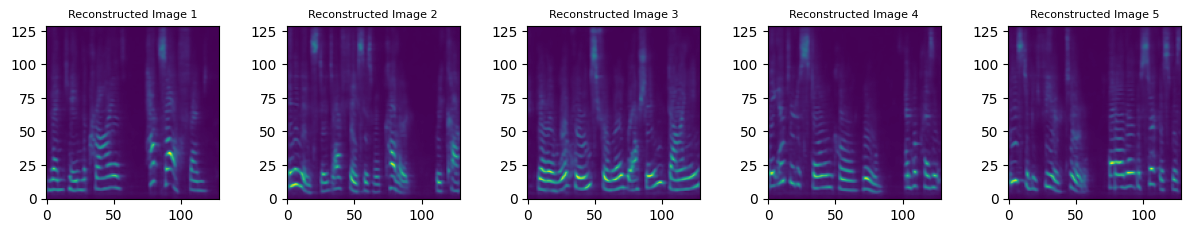

TRAIN - EPOCH 31/76 - loss: 0.0935
VALIDATION - EPOCH 31/76 - loss: 0.2023

--------------------------------------------------------------------------------
EPOCH 32/76
TRAIN - EPOCH 32/76 - loss: 0.0935
VALIDATION - EPOCH 32/76 - loss: 0.2043

--------------------------------------------------------------------------------
EPOCH 33/76
TRAIN - EPOCH 33/76 - loss: 0.0931
VALIDATION - EPOCH 33/76 - loss: 0.2024

--------------------------------------------------------------------------------
EPOCH 34/76
TRAIN - EPOCH 34/76 - loss: 0.0931
VALIDATION - EPOCH 34/76 - loss: 0.2025

--------------------------------------------------------------------------------
EPOCH 35/76
TRAIN - EPOCH 35/76 - loss: 0.0930
VALIDATION - EPOCH 35/76 - loss: 0.2040

--------------------------------------------------------------------------------
EPOCH 36/76
TRAIN - EPOCH 36/76 - loss: 0.0927
VALIDATION - EPOCH 36/76 - loss: 0.2010

-------------------------------------------------------------------------------

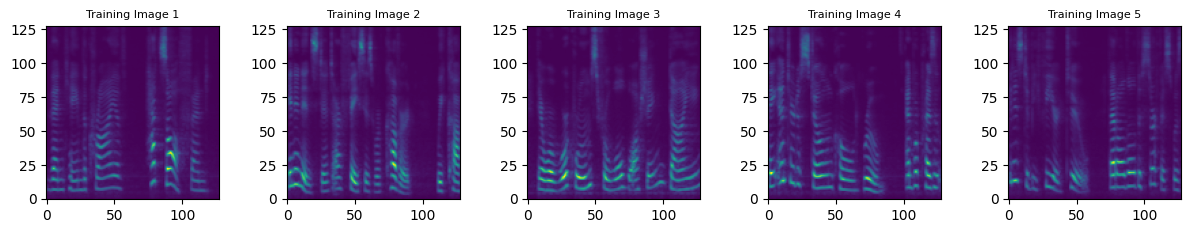

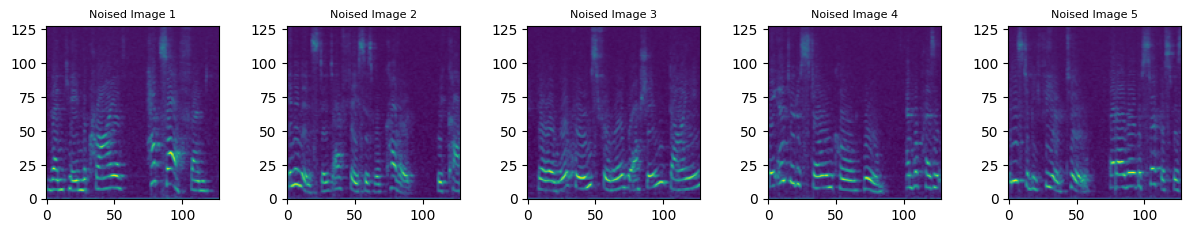

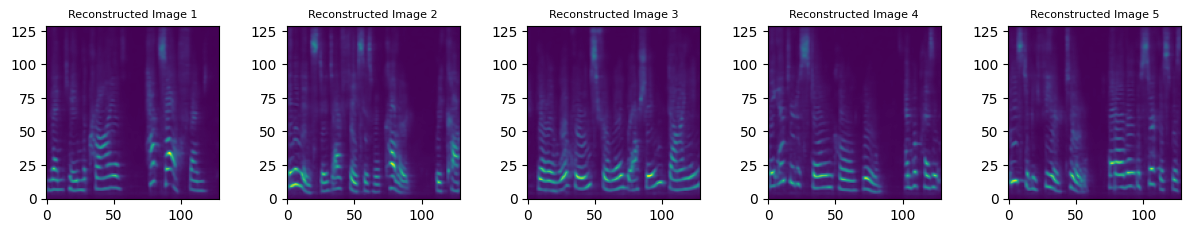

TRAIN - EPOCH 46/76 - loss: 0.0916
VALIDATION - EPOCH 46/76 - loss: 0.1992

--------------------------------------------------------------------------------
EPOCH 47/76
TRAIN - EPOCH 47/76 - loss: 0.0917
VALIDATION - EPOCH 47/76 - loss: 0.2006

--------------------------------------------------------------------------------
EPOCH 48/76
TRAIN - EPOCH 48/76 - loss: 0.0914
VALIDATION - EPOCH 48/76 - loss: 0.1989

--------------------------------------------------------------------------------
EPOCH 49/76
TRAIN - EPOCH 49/76 - loss: 0.0914
VALIDATION - EPOCH 49/76 - loss: 0.1986

--------------------------------------------------------------------------------
EPOCH 50/76
TRAIN - EPOCH 50/76 - loss: 0.0914
VALIDATION - EPOCH 50/76 - loss: 0.2008

--------------------------------------------------------------------------------
EPOCH 51/76
TRAIN - EPOCH 51/76 - loss: 0.0912
VALIDATION - EPOCH 51/76 - loss: 0.1978

-------------------------------------------------------------------------------

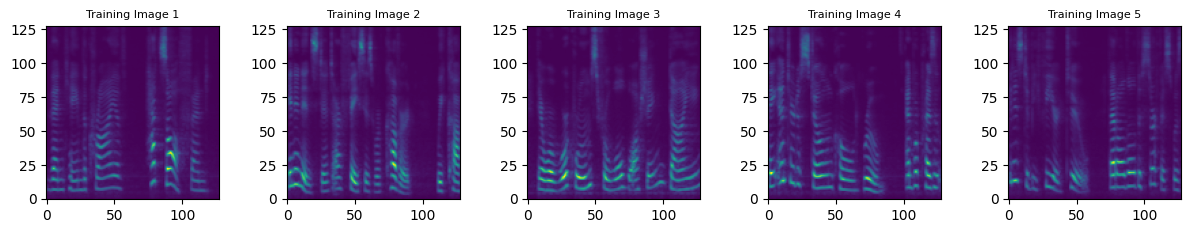

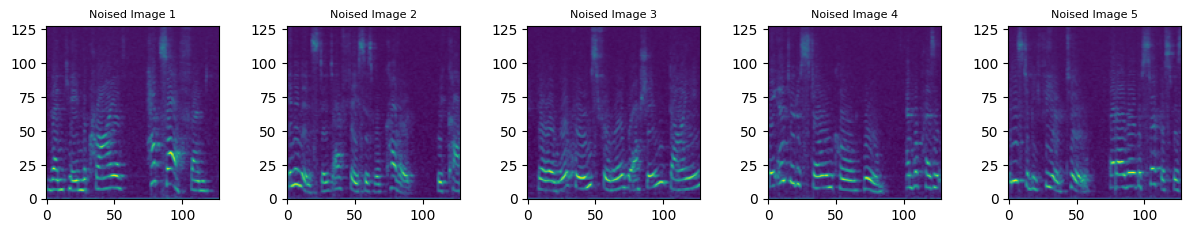

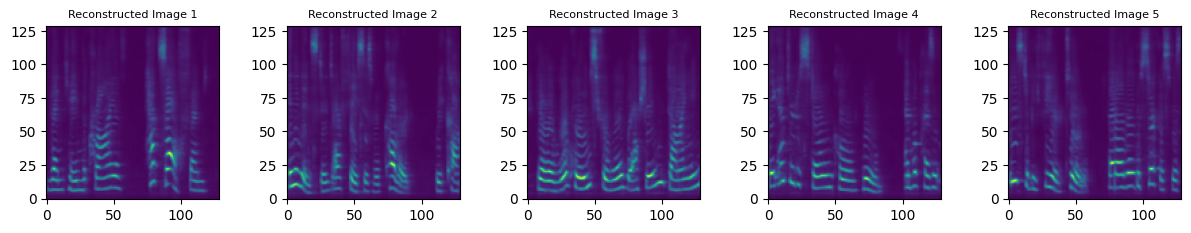

TRAIN - EPOCH 61/76 - loss: 0.0903
VALIDATION - EPOCH 61/76 - loss: 0.1975

--------------------------------------------------------------------------------
EPOCH 62/76
TRAIN - EPOCH 62/76 - loss: 0.0906
VALIDATION - EPOCH 62/76 - loss: 0.1971

--------------------------------------------------------------------------------
EPOCH 63/76
TRAIN - EPOCH 63/76 - loss: 0.0903
VALIDATION - EPOCH 63/76 - loss: 0.1966

--------------------------------------------------------------------------------
EPOCH 64/76
TRAIN - EPOCH 64/76 - loss: 0.0904
VALIDATION - EPOCH 64/76 - loss: 0.1956

--------------------------------------------------------------------------------
EPOCH 65/76
TRAIN - EPOCH 65/76 - loss: 0.0902
VALIDATION - EPOCH 65/76 - loss: 0.1948

--------------------------------------------------------------------------------
EPOCH 66/76
TRAIN - EPOCH 66/76 - loss: 0.0901
VALIDATION - EPOCH 66/76 - loss: 0.1953

-------------------------------------------------------------------------------

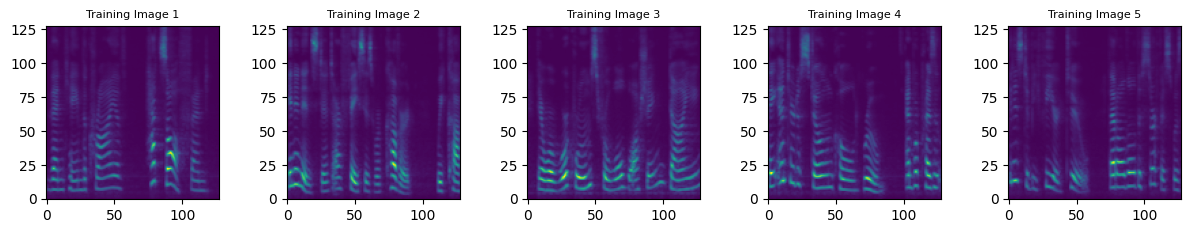

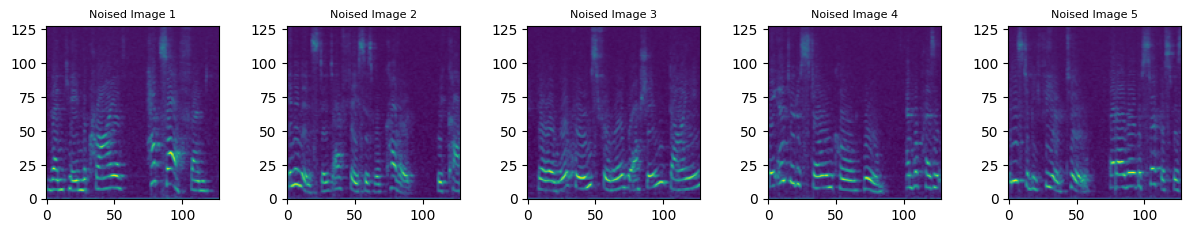

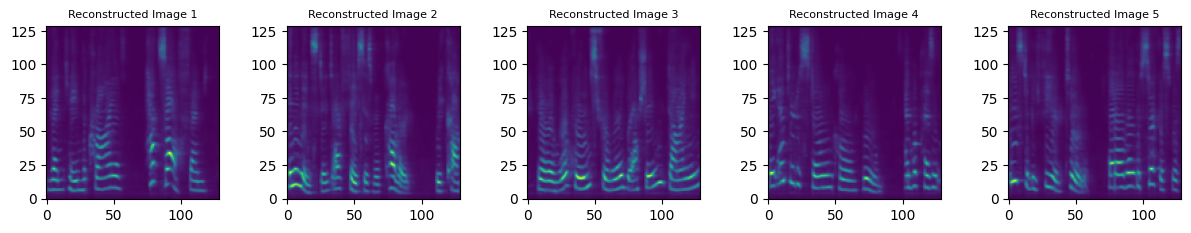

TRAIN - EPOCH 76/76 - loss: 0.0895
VALIDATION - EPOCH 76/76 - loss: 0.1951

--------------------------------------------------------------------------------


In [ ]:
### Initialize the two networks
encoder = Encoder()
decoder = Decoder()

### Define the loss function
loss_fn = torch.nn.L1Loss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 5e-4 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters(), "lr": 0.001}
]
weight_decay = 1e-5
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=weight_decay)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)


T1, V1 = [], []
### Training cycle
num_epochs = 76
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))

    ### Training (use the training function)
    train_loss = train_epoch(
        encoder=encoder,
        decoder=decoder,
        device=device,
        dataloader=dataloader,
        dataloader_noised=dataloader_noised,
        loss_fn=loss_fn,
        optimizer=optim,
        k=epoch,
        weight_decay=weight_decay,
        visualize=True)
    print(f'TRAIN - EPOCH {epoch+1}/{num_epochs} - loss: {train_loss:.4f}')
    T1.append(train_loss)

    ### Validation  (use the testing function)
    val_loss = test_epoch(
        encoder=encoder,
        decoder=decoder,
        device=device,
        dataloader=test_dataloader,
        dataloader_noised=test_dataloader_noised,
        loss_fn=loss_fn,
        weight_decay=weight_decay)
    # Print Validationloss
    print(f'VALIDATION - EPOCH {epoch+1}/{num_epochs} - loss: {val_loss:.4f}\n')
    V1.append(val_loss)

    print('--------------------------------------------------------------------------------')

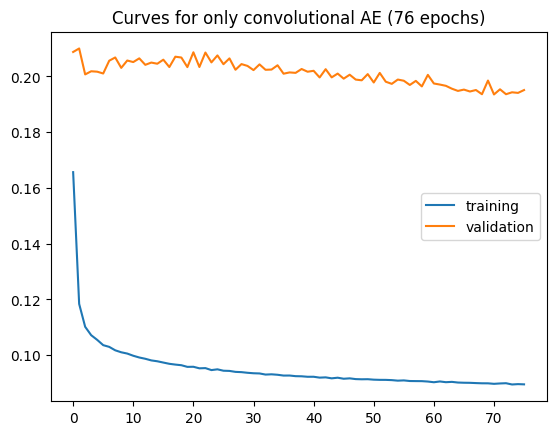

In [ ]:
plt.plot(T1, label='training')
V1_item = [x.item() for x in V1]
plt.plot(V1_item, label='validation')
plt.legend()
plt.title(f'Curves for only convolutional AE ({num_epochs} epochs)');

Observing the reconstructed spectrograms during training, we notice how this configuration is immediately proficient at correctly processing distorted spectra, achieving a high level of cleanliness. However, upon analyzing the validation curve, it becomes evident that the performance on this set is not favorable, and there is no indication of a gradual improvement. This is a clear sign of overfitting, suggesting that the model has essentially memorized the data and learned to restore it, but is unable to adapt this processing to external data outside the training set.

The reasons behind this overfitting can be manifold, primarily stemming from the limited dataset size, which, unfortunately, could not be expanded due to hardware constraints. One approach to mitigate overfitting could involve: reducing the model's complexity, exploring different types of regularization, or utilizing alternative loss functions.

Lets try this model over a training and a test data:

>Training Data

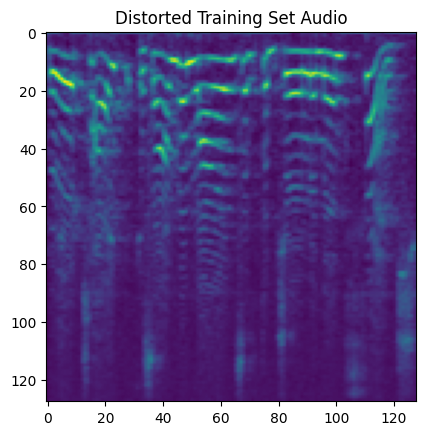

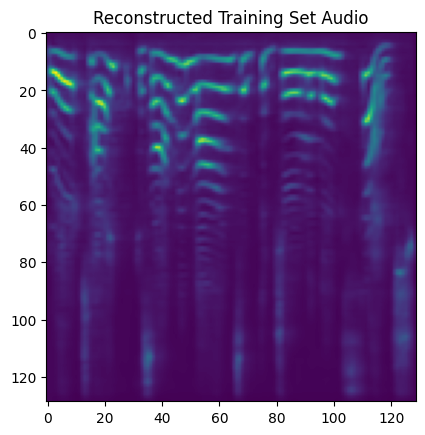

In [ ]:
test_tensor = custom_dataset_noised[0].unsqueeze(0).to(device)
test_encoded = encoder(test_tensor)
test_decoded = decoder(test_encoded)
# test_decoded.shape
numpy_decoded = test_decoded.squeeze().cpu().detach().numpy()
numpy_mel = numpy_decoded ** (4)
y_decoded = librosa.feature.inverse.mel_to_audio(numpy_mel)
yo = librosa.feature.inverse.mel_to_audio((test_tensor**4).squeeze().cpu().detach().numpy())
# display
plt.figure()
plt.title(f'Distorted Training Set Audio')
plt.imshow(test_tensor.squeeze().cpu().detach().numpy())
plt.show()
display(Audio(yo, rate=22050))
plt.figure()
plt.title(f'Reconstructed Training Set Audio')
plt.imshow(numpy_decoded)
plt.show()
display(Audio(y_decoded, rate=22050))

> Test Data

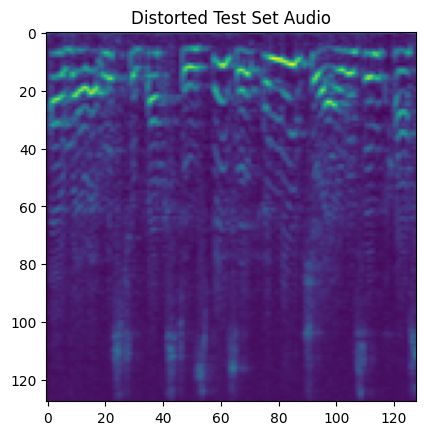

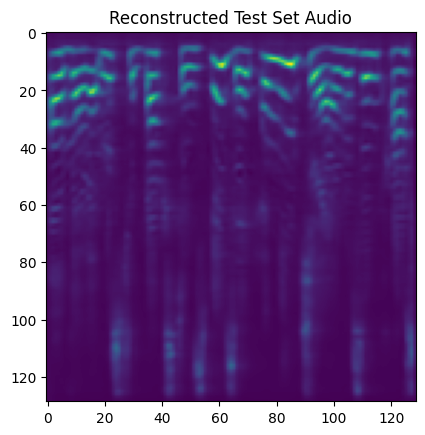

In [ ]:
test_tensor = test_dataset_noised[0].unsqueeze(0).to(device)
test_encoded = encoder(test_tensor)
test_decoded = decoder(test_encoded)
# test_decoded.shape
numpy_decoded = test_decoded.squeeze().cpu().detach().numpy()
numpy_mel = numpy_decoded ** (4)
y_decoded = librosa.feature.inverse.mel_to_audio(numpy_mel)
yo = librosa.feature.inverse.mel_to_audio((test_tensor**4).squeeze().cpu().detach().numpy())
# display
plt.figure()
plt.title(f'Distorted Test Set Audio')
plt.imshow(test_tensor.squeeze().cpu().detach().numpy())
plt.show()
display(Audio(yo, rate=22050))
plt.figure()
plt.title(f'Reconstructed Test Set Audio')
plt.imshow(numpy_decoded)
plt.show()
display(Audio(y_decoded, rate=22050))

We observe that in the case of reconstruction on an example outside the training set, the model still performs adequately well for the human ear, despite the computed error being noticeably higher compared to the reconstruction with a spectrogram from the training set

This suggests that, in this particular case (limited dataset and common distortion within the dataset), an autoencoder with only convolutional layers outperforms one with a fully connected layer in the middle. The question we now pose is: is there a way to enhance the algorithm? Can we mitigate the overfitting phenomenon just observed?

-------------------------------------------------------------------------------------------
Comparing different Loss Functions: *Mean Squared Error*, *Mean Absolute Error*, *SSIM*

**About Structural Similarity Index Metric (SSIM)**

The SSIM metric is a widely used indicator for evaluating the quality of images. It provides a measure of how similar two images are in structure. A high SSIM indicates greater similarity between the images.

The SSIM metric is based on three main components:
- **Luminance (L)**: Measures the average luminance difference between the two images.
- **Contrast (C)**: Measures how different the contrast of the sample image is from the reference image.
- **Structure (S)**: Evaluates the similarity of the detail structures between the two images.

The total SSIM is the product of these three components: $SSIM = L^α ⋅C^\beta \cdot S^\gamma$, where for semplicity usually is computated with $\alpha = \beta = \gamma = 1$.

## Formulas
The specific formulas to calculate the SSIM components are as follows:

- **Luminance (L)**:
 $$L(x, y) = \frac{{2 \cdot \mu_x \cdot \mu_y + C_1}}{{\mu_x^2 + \mu_y^2 + C_1}} $$

- **Contrast (C)**:
 $$C(x, y) = \frac{{2 \cdot \sigma_x \cdot \sigma_y + C_2}}{{\sigma_x^2 + \sigma_y^2 + C_2}} $$

- **Structure (S)**:
 $$S(x, y) = \frac{{\sigma_{xy} + C_3}}{{\sigma_x \cdot \sigma_y + C_3}} $$

Where:
- \( $\mu_x, \mu_y $\) are the means of the reference and sample images.
- \( $\sigma_x, \sigma_y $\) are the standard deviations of the reference and sample images.
- \( $\sigma_{xy} $\) is the covariance between the two images.
- \( $C_1, C_2, C_3 $\) are constants to stabilize the calculation.

The SSIM value returns a value between -1 and 1, where 1 indicates perfect structural similarity between the images. A value closer to 1 indicates better quality. In order to minimize the error, we employ the following formulation:
$$ error = 1 - SSIM $$



In [ ]:
from torchmetrics.image import StructuralSimilarityIndexMeasure

### Training function
def train_epoch_2(encoder, decoder, device, dataloader, dataloader_noised, optimizer, k, weight_decay, err='MSE', visualize=False):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    losses = []
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for j, (image_batch, image_batch_noised) in enumerate(zip(dataloader, dataloader_noised)):
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        image_batch_noised = image_batch_noised.to(device)
        # Decode data
        encoded_data = encoder(image_batch_noised)
        decoded_data = decoder(encoded_data)
        decoded_data = decoded_data[:,:,:-1,:-1]

        # Calculate the reconstruction loss
        if err == 'SSIM':
            reconstruction_loss = 1 - ssim(decoded_data, image_batch)
        else:
            if err == 'MSE':
                loss_fn = torch.nn.MSELoss().to(device)
            elif err == 'MAE':
                loss_fn = torch.nn.L1Loss()
            reconstruction_loss = loss_fn(decoded_data, image_batch)



        # Calculate the regularization term (L2 norm of the parameters)
        l2_regularization = 0.0
        for param in encoder.parameters():
            l2_regularization += torch.norm(param)**2
        for param in decoder.parameters():
            l2_regularization += torch.norm(param)**2
        l2_regularization *= 0.5 * weight_decay

        # Add the regularization term to the loss
        loss = reconstruction_loss + l2_regularization
        #-----------------------------

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.detach().cpu().numpy())
        # print(f'------ Loss: {loss:.4f}')
    losses = np.mean(losses)

    if visualize:
        if k % 20 == 0:
            print_recons(image_batch, image_batch_noised, decoded_data)

    return losses

def test_epoch_2(encoder, decoder, device, dataloader, dataloader_noised, weight_decay, err='MSE'):
    encoder.eval()
    decoder.eval()

    ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

    with torch.no_grad():
        conc_out = []
        conc_label = []
        l2_regularization = 0.0

        for image_batch, image_batch_noised in zip(dataloader, dataloader_noised):
            image_batch = image_batch.to(device)
            image_batch_noised = image_batch_noised.to(device)

            encoded_data = encoder(image_batch_noised)
            decoded_data = decoder(encoded_data)
            decoded_data = decoded_data[:,:,:-1,:-1]

            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())

            # Calculate the L2 regularization term
            for param in encoder.parameters():
                l2_regularization += torch.norm(param)**2
            for param in decoder.parameters():
                l2_regularization += torch.norm(param)**2

        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)

        # Calculate the reconstruction loss
        if err == 'SSIM':
            reconstruction_loss = 1 - ssim(decoded_data, image_batch)
        else:
            if err == 'MSE':
                loss_fn = torch.nn.MSELoss().to(device)
            elif err == 'MAE':
                loss_fn = torch.nn.L1Loss()
            reconstruction_loss = loss_fn(decoded_data, image_batch)

        # Calculate the total loss with L2 regularization
        l2_regularization *= 0.5 * weight_decay
        val_loss = reconstruction_loss + l2_regularization

    return val_loss.data

In [ ]:
training_curves_2_copy = training_curves_2.copy()
validation_curves_2_copy = validation_curves_2.copy()

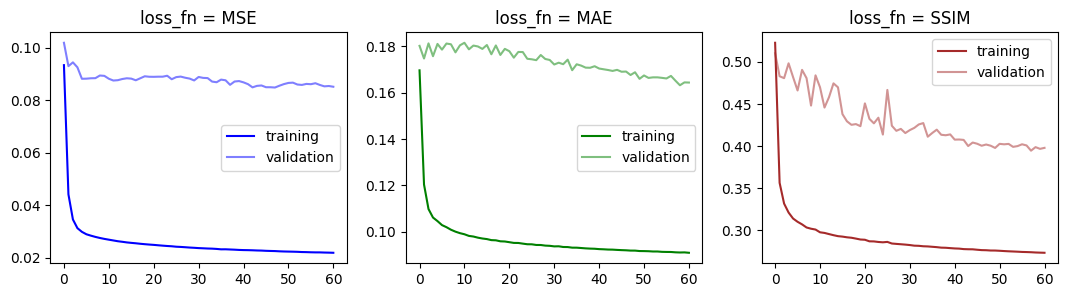

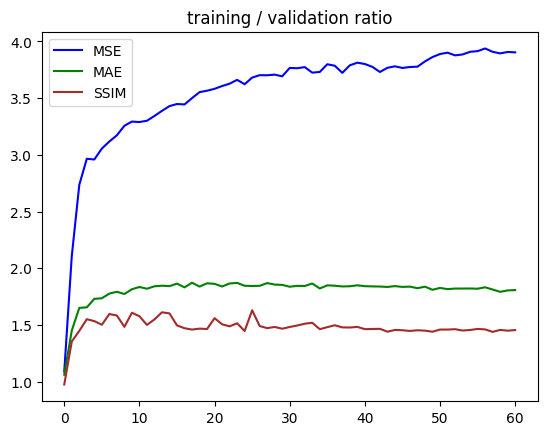

In [ ]:
ratios_curve_2 = []
colors = ['blue', 'green', 'brown']
fig, ax = plt.subplots(1, 3, figsize=(13, 3))
for i, err in enumerate(err_types):
    ratios_curve_2.append( validation_curves_2_copy[i] / training_curves_2_copy[i] )
    AX = ax[i]
    AX.set_title(f'loss_fn = {err}')
    AX.plot(training_curves_2_copy[i], c=colors[i], label=f'training')
    AX.plot(validation_curves_2_copy[i], c=colors[i], alpha=0.5, label=f'validation')
    AX.legend()
plt.show()

plt.figure()
for j, r in enumerate(ratios_curve_2):
    plt.title(f'training / validation ratio')
    plt.plot(r, c=colors[j], label=f'{err_types[j]}')
plt.legend();

Given that direct comparisons are not feasible as each metric is self-referential, these graphs depict how, for each type of loss function, the Training and Validation curves vary. We specifically focus on overfitting, indirectly suggested by the relationship between the training and validation curves. We observe that in the case of the Structural Similarity Index Metric (SSIM), the validation curve appears to exhibit a more pronounced decreasing trend compared to the other two. This indicates that the algorithm trained with SSIM ensures a good performance even with data external to the training set.

In [ ]:
# save arrays
np.save("/content/drive/MyDrive/NNDL/training_curves_2.npy", training_curves_2)
np.save("/content/drive/MyDrive/NNDL/validation_curves_2.npy", validation_curves_2)
np.save("/content/drive/MyDrive/NNDL/T1.npy", T1)
np.save("/content/drive/MyDrive/NNDL/V1_item.npy", V1_item)
print('file loaded!')

file loaded!


--------------------------------------------------------------------------------------------------------------------------------------------

## Different number of convolutional layers

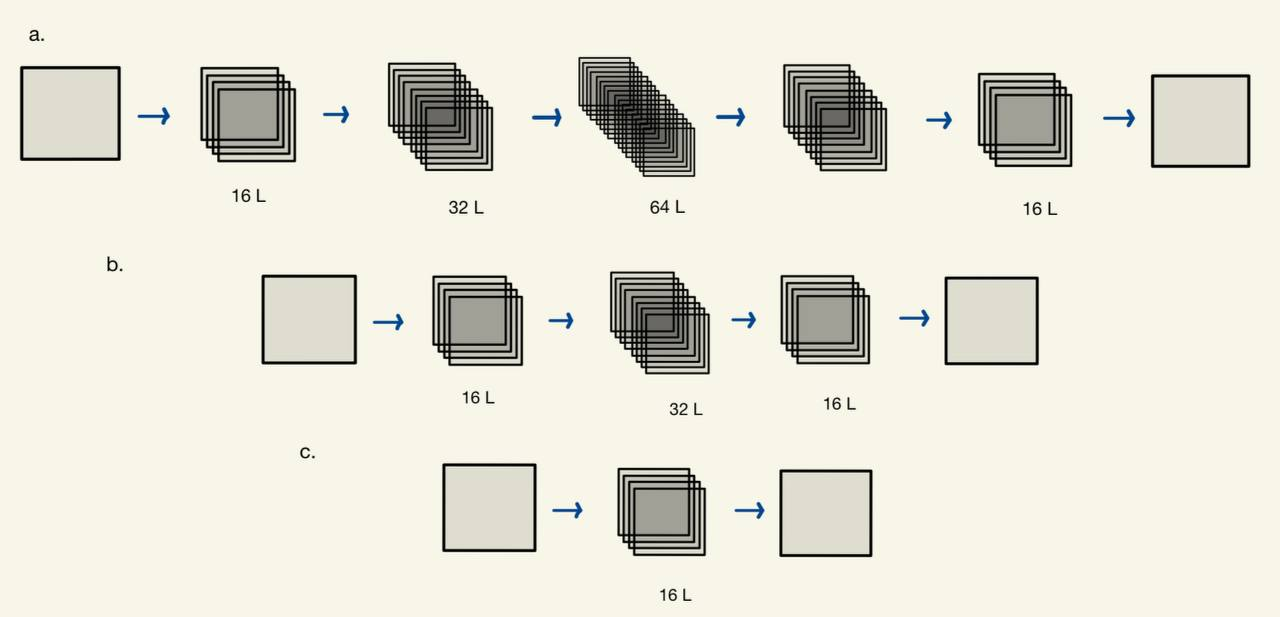

In [ ]:
# ENCODER - DECODER

class Encoder_A(nn.Module):

    def __init__(self):
        super().__init__()

        ### Convolutional section
        self.encoder_cnn = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, 3, stride=1, padding=1),
            torch.nn.Dropout(0.2),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2, stride=1),
            torch.nn.Conv2d(16, 32, 3, stride=1, padding=1),  # b, 8, 3, 3
            torch.nn.Dropout(0.2),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2, stride=1),  # b, 8, 2, 2
            torch.nn.Conv2d(32, 64, 3, stride=1, padding=1),  # b, 8, 3, 3
            torch.nn.Dropout(0.2),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2, stride=1)
        )

    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        return x

class Decoder_A(nn.Module):

  def __init__(self):
      super().__init__()

      ### Convolutional section
      self.decoder_conv =nn.Sequential(
          torch.nn.Upsample(scale_factor=1, mode='nearest'),
          torch.nn.Conv2d(64, 32, 3, stride=1, padding=1),  # b, 16, 10, 10
          torch.nn.ReLU(True),
          torch.nn.Upsample(scale_factor=1, mode='nearest'),
          torch.nn.Conv2d(32, 16, 3, stride=1, padding=2),  # b, 16, 10, 10
          torch.nn.ReLU(True),
          torch.nn.Upsample(scale_factor=1, mode='nearest'),
          torch.nn.Conv2d(16, 1, 5, stride=1, padding=3)  # b, 8, 3, 3

          # torch.nn.Sigmoid()
      )

  def forward(self, x):
      # Apply transposed convolutions
      x = self.decoder_conv(x)
      return x
#----------------------------------------------------------------------------------------
# ENCODER - DECODER

class Encoder_B(nn.Module):

    def __init__(self):
        super().__init__()

        ### Convolutional section
        self.encoder_cnn = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, 3, stride=1, padding=1),
            torch.nn.Dropout(0.2),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2, stride=1),
            torch.nn.Conv2d(16, 32, 3, stride=1, padding=1),  # b, 8, 3, 3
            torch.nn.Dropout(0.2),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2, stride=1)
        )

    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        return x

class Decoder_B(nn.Module):

  def __init__(self):
      super().__init__()

      ### Convolutional section
      self.decoder_conv =nn.Sequential(
          torch.nn.Upsample(scale_factor=1, mode='nearest'),
          torch.nn.Conv2d(32, 16, 3, stride=1, padding=2),  # b, 16, 10, 10
          torch.nn.ReLU(True),
          torch.nn.Upsample(scale_factor=1, mode='nearest'),
          torch.nn.Conv2d(16, 1, 5, stride=1, padding=3)
      )

  def forward(self, x):
      # Apply transposed convolutions
      x = self.decoder_conv(x)
      return x

#----------------------------------------------------------------------------------------
# ENCODER - DECODER

class Encoder_C(nn.Module):

    def __init__(self):
        super().__init__()

        ### Convolutional section
        self.encoder_cnn = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, 3, stride=1, padding=1),
            torch.nn.Dropout(0.2),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2, stride=1),
        )

    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        return x

class Decoder_C(nn.Module):

  def __init__(self):
      super().__init__()

      ### Convolutional section
      self.decoder_conv =nn.Sequential(
          torch.nn.Upsample(scale_factor=1, mode='nearest'),
          torch.nn.Conv2d(16, 1, 5, stride=1, padding=3)
      )

  def forward(self, x):
      # Apply transposed convolutions
      x = self.decoder_conv(x)
      return x

In [ ]:
### Training function
def train_epoch_3(encoder, decoder, device, dataloader, dataloader_noised, optimizer, k, weight_decay, err='MSE', visualize=False):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    losses = []
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for j, (image_batch, image_batch_noised) in enumerate(zip(dataloader, dataloader_noised)):
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        image_batch_noised = image_batch_noised.to(device)
        # Decode data
        encoded_data = encoder(image_batch_noised)
        decoded_data = decoder(encoded_data)
        decoded_data = decoded_data[:,:,:128,:128]

        # Calculate the reconstruction loss
        if err == 'SSIM':
            reconstruction_loss = 1 - ssim(decoded_data, image_batch)
        else:
            if err == 'MSE':
                loss_fn = torch.nn.MSELoss().to(device)
            elif err == 'MAE':
                loss_fn = torch.nn.L1Loss()
            reconstruction_loss = loss_fn(decoded_data, image_batch)



        # Calculate the regularization term (L2 norm of the parameters)
        l2_regularization = 0.0
        for param in encoder.parameters():
            l2_regularization += torch.norm(param)**2
        for param in decoder.parameters():
            l2_regularization += torch.norm(param)**2
        l2_regularization *= 0.5 * weight_decay

        # Add the regularization term to the loss
        loss = reconstruction_loss + l2_regularization
        #-----------------------------

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.detach().cpu().numpy())
        # print(f'------ Loss: {loss:.4f}')
    losses = np.mean(losses)

    if visualize:
        if k % 20 == 0:
            print_recons(image_batch, image_batch_noised, decoded_data)

    return losses

def test_epoch_3(encoder, decoder, device, dataloader, dataloader_noised, weight_decay, err='MSE'):
    encoder.eval()
    decoder.eval()

    ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

    with torch.no_grad():
        conc_out = []
        conc_label = []
        l2_regularization = 0.0

        for image_batch, image_batch_noised in zip(dataloader, dataloader_noised):
            image_batch = image_batch.to(device)
            image_batch_noised = image_batch_noised.to(device)

            encoded_data = encoder(image_batch_noised)
            decoded_data = decoder(encoded_data)
            decoded_data = decoded_data[:,:,:128,:128]

            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())

            # Calculate the L2 regularization term
            for param in encoder.parameters():
                l2_regularization += torch.norm(param)**2
            for param in decoder.parameters():
                l2_regularization += torch.norm(param)**2

        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)

        # Calculate the reconstruction loss
        if err == 'SSIM':
            reconstruction_loss = 1 - ssim(decoded_data, image_batch)
        else:
            if err == 'MSE':
                loss_fn = torch.nn.MSELoss().to(device)
            elif err == 'MAE':
                loss_fn = torch.nn.L1Loss()
            reconstruction_loss = loss_fn(decoded_data, image_batch)

        # Calculate the total loss with L2 regularization
        l2_regularization *= 0.5 * weight_decay
        val_loss = reconstruction_loss + l2_regularization

    return val_loss.data

In [ ]:
# prova con tutti
data = custom_dataset_noised[0].unsqueeze(0).to(device)
print(type(data))
encoderA, encoderB, encoderC = Encoder_A().to(device), Encoder_B().to(device), Encoder_C().to(device)
decoderA, decoderB, decoderC = Decoder_A().to(device), Decoder_B().to(device), Decoder_C().to(device)
# A
eA = encoderA(data)
dA = decoderA(eA)
print(dA.shape)
# B
eB = encoderB(data)
dB = decoderB(eB)
print(dB.shape)
# C
eC = encoderC(data)
dC = decoderC(eC)
print(dC.shape)

<class 'torch.Tensor'>
torch.Size([1, 1, 129, 129])
torch.Size([1, 1, 130, 130])
torch.Size([1, 1, 129, 129])


In [ ]:
training_curves_3_copy = training_curves_3.copy()
validation_curves_3_copy = validation_curves_3.copy()

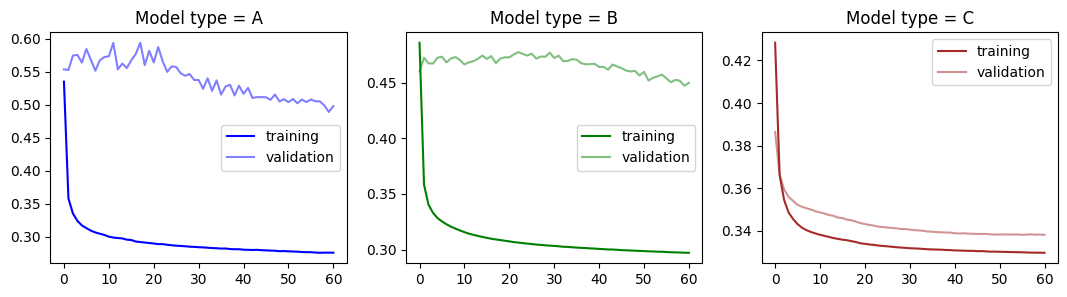

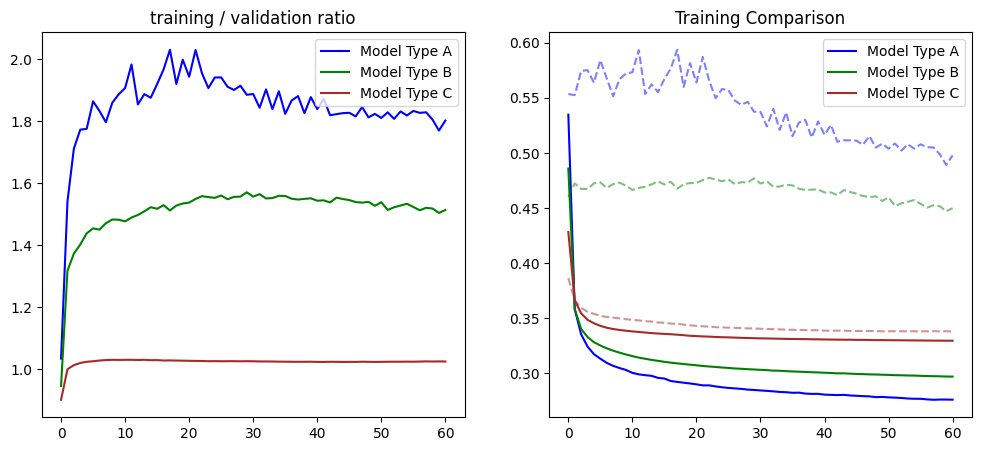

In [ ]:
ratios_curve_3 = []
colors = ['blue', 'green', 'brown']
fig, ax = plt.subplots(1, 3, figsize=(13, 3))
for i, model_type in enumerate(model_types):
    ratios_curve_3.append( validation_curves_3_copy[i] / training_curves_3_copy[i] )
    AX = ax[i]
    AX.set_title(f'Model type = {model_type}')
    AX.plot(training_curves_3_copy[i], c=colors[i], label=f'training')
    AX.plot(validation_curves_3_copy[i], c=colors[i], alpha=0.5, label=f'validation')
    AX.legend()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12,5))
for j, r in enumerate(ratios_curve_3):
    ax[0].set_title(f'training / validation ratio')
    ax[0].plot(r, c=colors[j], label=f'Model Type {model_types[j]}')
    ax[1].set_title('Training Comparison')
    ax[1].plot(training_curves_3_copy[j], c=colors[j], label=f'Model Type {model_types[j]}')
    ax[1].plot(validation_curves_3_copy[j], linestyle='dashed', c=colors[j], alpha=0.5)
ax[0].legend()
ax[1].legend();

The above graphs indicate that by reducing the complexity of the models (i.e., decreasing the number of convolutional layers), two main consequences arise. On one hand, overfitting diminishes, evident in how the ratio between validation and training curves progressively decreases. On the other hand, there is a lower overall efficiency in audio cleaning, as demonstrated by the comparison of the training curves.

Trials with Training and Test Distorted Audio

> Training

In [ ]:
test_tensor = custom_dataset_noised[0].unsqueeze(0).to(device)
yo = librosa.feature.inverse.mel_to_audio((test_tensor**4).squeeze().cpu().detach().numpy())
print(f'Original Distrorted Audio')
display(Audio(yo, rate=22050))
yy = []
for i, (enc, dec) in enumerate(zip(encoders, decoders)):
    test_encoded = enc(test_tensor)
    test_decoded = dec(test_encoded)
    numpy_decoded = test_decoded.squeeze().cpu().detach().numpy()
    numpy_mel = numpy_decoded ** (4)
    y_decoded = librosa.feature.inverse.mel_to_audio(numpy_mel)
    yy.append(y_decoded)
    print(f'\nModel Type: {model_types[i]}')
    display(Audio(y_decoded, rate=22050))

Original Distrorted Audio



Model Type: A



Model Type: B



Model Type: C


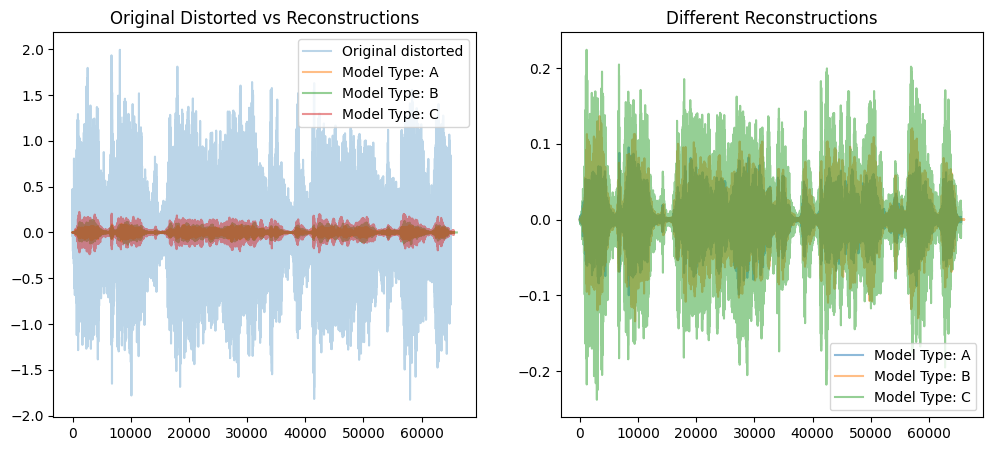

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].plot(yo, alpha=0.3, label='Original distorted')
for i in range(3):
  ax[0].plot(yy[i], alpha=0.5, label=f'Model Type: {model_types[i]}')
ax[0].set_title('Original Distorted vs Reconstructions')
ax[0].legend()

for i in range(3):
  ax[1].plot(yy[i], alpha=0.5, label=f'Model Type: {model_types[i]}')
ax[1].set_title('Different Reconstructions')
ax[1].legend();

> Test

In [ ]:
test_tensor = test_dataset_noised[20].unsqueeze(0).to(device)
yo = librosa.feature.inverse.mel_to_audio((test_tensor**4).squeeze().cpu().detach().numpy())
print(f'Original Distrorted Audio')
display(Audio(yo, rate=22050))

yy = []
for i, (enc, dec) in enumerate(zip(encoders, decoders)):
    test_encoded = enc(test_tensor)
    test_decoded = dec(test_encoded)
    numpy_decoded = test_decoded.squeeze().cpu().detach().numpy()
    numpy_mel = numpy_decoded ** (4)
    y_decoded = librosa.feature.inverse.mel_to_audio(numpy_mel)
    yy.append(y_decoded)
    print(f'\nModel Type: {model_types[i]}')
    display(Audio(y_decoded, rate=22050))

Original Distrorted Audio



Model Type: A



Model Type: B



Model Type: C


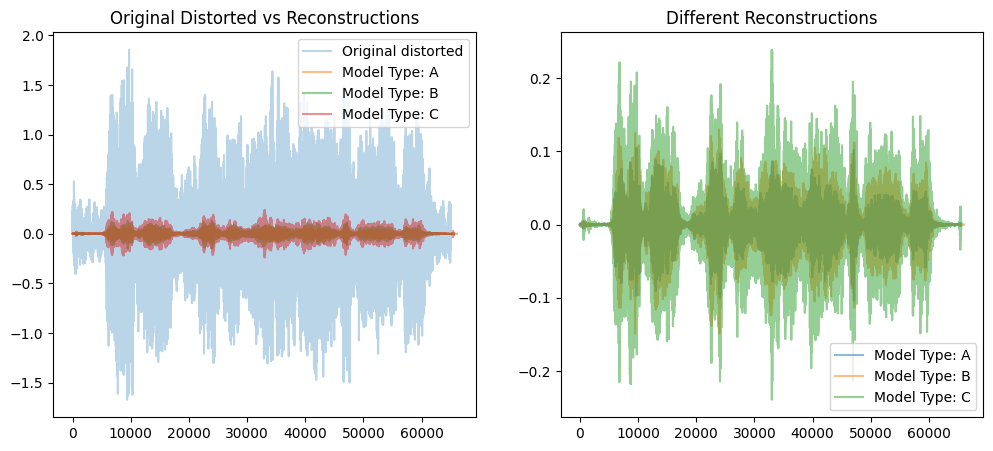

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].plot(yo, alpha=0.3, label='Original distorted')
for i in range(3):
  ax[0].plot(yy[i], alpha=0.5, label=f'Model Type: {model_types[i]}')
ax[0].set_title('Original Distorted vs Reconstructions')
ax[0].legend()

for i in range(3):
  ax[1].plot(yy[i], alpha=0.5, label=f'Model Type: {model_types[i]}')
ax[1].set_title('Different Reconstructions')
ax[1].legend();

In conclusion, we can observe and perceive that, thanks to the (slightly) improved handling of overfitting, even with a very basic model like type "C" (which has only one convolutional layer), we achieve a satisfactory level of cleanliness. It can be stated that all three models perform well in the task of noise removal, though subtle differences in quality restoration are perceptible among them.